# **YoloV5(PyTorch) 모델 실습**
- PyTorch 기반의 YoloV5 모델을 활용한 객체 탐지(Object Detection) 실습
- VOC 데이터를 사용해 실습을 진행하며, 이미지에서 물체를 탐지하고 결과를 시각화 방법

## **1. 사전 환경 세팅**
- 필요한 라이브러리 설치 및 불러오기
- 모델 파일 및 관련 설정 파일 준비

### **1-1. PyTorch 정상 설치 확인**
- PyTorch는 딥러닝 모델을 구축 및 학습시키는 데 주로 사용되는 프레임워크
- 설치 확인을 통해 실행 환경이 올바르게 설정되었는지 점검

In [20]:
# S3 드라이브에서 datasets.zip 파일 받아서 yolov5/../datasets 위치에 저장
# S3 드라이브에서 checkpoints.zip 파일 받아서 yolov5/ 위치에 저장

In [ ]:
# Conda 환경 생성 및 활성화
# 새로운 Conda 환경(day14-1)을 생성하고 Python 3.9 버전 설치

# day14-1이라는 이름의 Conda 환경 생성
# conda create -n day14-2 python=3.9

# 생성한 day14-1 환경 활성화
# conda activate day14-2

# 필요한 패키지 설치 및 Jupyter Notebook 설정
# requirements.txt 파일을 통해 필요한 패키지 설치
# pip install -r requirements.txt

# Jupyter Notebook 설치
# pip install jupyter notebook

# Jupyter Notebook에서 새로운 Conda 커널 설정
# python -m ipykernel install --user --name day14-2 --display-name day14-2

In [ ]:
# PyTorch 라이브러리 불러오기
import torch

# PyTorch 버전 확인
print(torch.__version__) # PyTorch 버전 출력

2.5.1+cu124


### **1-2. Pre-trained weight로 추론 진행**

In [7]:
# pretrained weight 인 yolov5l.pt 를 활용해 data/bus.jpg 이미지에 대해 추론 진행
# !python detect.py --weights yolov5s.pt --source /workspace/yolov5/data/images/bus.jpg
!python detect.py --weights yolov5l.pt --source ./data/images/zidane.jpg
                                            #    img.jpg                         # image
                                            #    vid.mp4                         # video
                                            #    screen                          # screenshot
                                            #    path/                           # directory
                                            #    list.txt                        # list of images
                                            #    list.streams                    # list of streams
                                            #    'path/*.jpg'                    # glob
                                            #    'https://youtu.be/LNwODJXcvt4'  # YouTube
                                            #    'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream

detect: weights=['yolov5l.pt'], source=./data/images/zidane.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2024-12-5 Python-3.9.20 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 11932MiB)

100%|██████████████████████████████████████| 89.3M/89.3M [00:02<00:00, 33.5MB/s]

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
image 1/1 /workspace/Day-14/yolov5/data/images/zidane.jpg: 384x640 2 persons, 1 tie, 25.7ms
Speed: 0.2ms pre-process, 25.7ms inference, 51.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp5


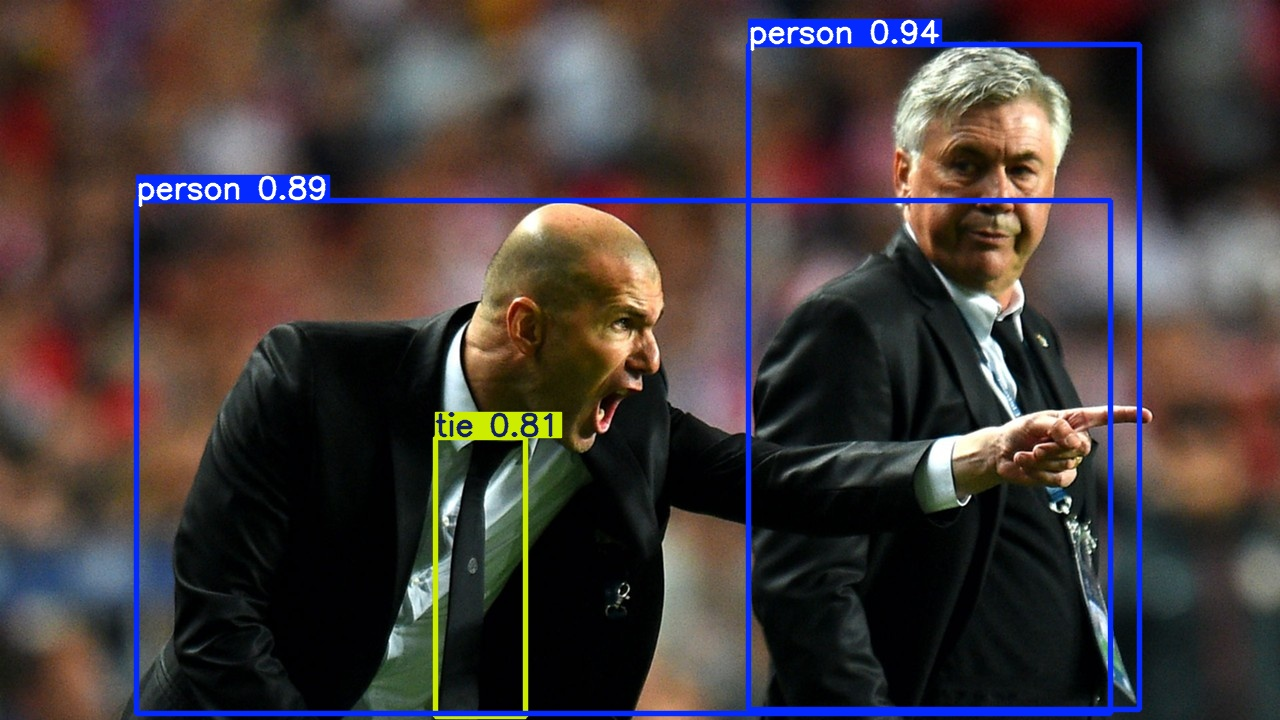

In [8]:
# 1. 필요한 모듈 로드
# 이미지 시각화를 위해 IPython.display 모듈의 Image와 display 함수 사용
from IPython.display import Image, display

# 파일 검색과 디렉터리 작업을 위해 glob와 os 모듈 사용
import glob
import os

# 2. 최신 추론 결과 디렉터리 탐색
# runs/detect/ 경로 내 "exp*" 패턴에 맞는 디렉터리 검색
exp_dirs = sorted(
    glob.glob('runs/detect/exp*'),  # "exp*" 패턴에 맞는 디렉터리 검색
    key=os.path.getmtime           # 마지막 수정 시간을 기준으로 정렬
)
# 최신 디렉터리 선택 (존재하지 않으면 None)
latest_exp_dir = exp_dirs[-1] if exp_dirs else None

# 3. 결과 이미지 확인 및 시각화
if latest_exp_dir:  # 최신 디렉터리가 존재할 경우
    # 최신 디렉터리 내 .jpg 이미지 파일 검색
    result_images = glob.glob(os.path.join(latest_exp_dir, '*.jpg'))
    
    if result_images:  # 이미지 파일이 있을 경우
        # 첫 번째 이미지 화면에 출력
        display(Image(filename=result_images[0]))
    else:  # 이미지 파일이 없을 경우
        print("No result images found in the latest directory.")
else:  # "exp*" 디렉터리가 없을 경우
    print("No 'exp*' directories found.")

## **2. VOC 데이터셋 전처리**

In [9]:
# 1. 필요한 모듈 로드
# os와 pathlib 모듈: 파일 및 디렉터리 작업
import os
from pathlib import Path

# xml.etree.ElementTree: Pascal VOC 형식의 XML 파일을 처리
import xml.etree.ElementTree as ET

# tqdm: 작업 진행 상황을 표시하는 진행 바
from tqdm import tqdm

# requests: 인터넷에서 파일 다운로드
import requests

# zipfile: zip 파일 압축 해제
import zipfile

# 2. 함수: VOC 라벨을 YOLO 포맷으로 변환
def convert_label(annotation_path, label_path, class_names):
    # 박스 정보를 VOC 형식에서 YOLO 형식으로 변환
    def convert_box(size, box):
        dw, dh = 1. / size[0], 1. / size[1]
        x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
        return x * dw, y * dh, w * dw, h * dh

    # XML 파일 파싱
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # 이미지 크기 가져오기
    size = root.find('size')
    width, height = int(size.find('width').text), int(size.find('height').text)

    # YOLO 라벨 파일 생성
    with open(label_path, 'w') as out_file:
        for obj in root.iter('object'):  # 객체별로 반복
            cls = obj.find('name').text
            # 클래스가 유효하고, "difficult" 속성이 1이 아닌 경우 처리
            if cls in class_names and int(obj.find('difficult').text) != 1:
                xmlbox = obj.find('bndbox')
                box = [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')]
                bbox = convert_box((width, height), box)
                cls_id = class_names.index(cls)
                # YOLO 포맷으로 파일에 작성
                out_file.write(f"{cls_id} " + " ".join(map(str, bbox)) + '\n')

# 3. 함수: URL에서 파일 다운로드
def download_file(url, dest_path):
    print(f"Downloading {url}...")
    response = requests.get(url, stream=True)  # 스트리밍 모드로 파일 다운로드
    response.raise_for_status()  # 다운로드 실패 시 예외 발생
    with open(dest_path, 'wb') as f:  # 바이너리 모드로 파일 저장
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Saved to {dest_path}")

# 4. 함수: VOC 데이터셋 다운로드 및 준비
def download_and_prepare_voc():
    # 데이터셋 저장 디렉터리 설정
    base_dir = Path('./datasets/VOC')
    images_dir = base_dir / 'images'
    labels_dir = base_dir / 'labels'
    images_dir.mkdir(parents=True, exist_ok=True)  # 디렉터리 생성
    labels_dir.mkdir(parents=True, exist_ok=True)

    # VOC 데이터셋 다운로드 URL
    voc_urls = {
        'VOCtrainval_06-Nov-2007': 'https://github.com/ultralytics/assets/releases/download/v0.0.0/VOCtrainval_06-Nov-2007.zip',
        'VOCtest_06-Nov-2007': 'https://github.com/ultralytics/assets/releases/download/v0.0.0/VOCtest_06-Nov-2007.zip',
        'VOCtrainval_11-May-2012': 'https://github.com/ultralytics/assets/releases/download/v0.0.0/VOCtrainval_11-May-2012.zip'
    }

    # 각 URL에서 데이터 다운로드 및 압축 해제
    for name, url in voc_urls.items():
        zip_path = base_dir / f"{name}.zip"
        if not zip_path.exists():  # 파일이 없는 경우에만 다운로드
            download_file(url, zip_path)

        # 압축 해제
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(images_dir)

    # VOCdevkit 디렉터리 경로 설정
    voc_path = images_dir / 'VOCdevkit'
    if not voc_path.exists():  # 압축 해제 실패 시 예외 발생
        raise FileNotFoundError("VOCdevkit directory not found after extraction.")

    # Pascal VOC 클래스 목록
    class_names = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
        'train', 'tvmonitor'
    ]

    # 데이터셋 변환 (train, val, test 세트 처리)
    for year, image_set in [('2007', 'train'), ('2007', 'val'), ('2007', 'test'), ('2012', 'train'), ('2012', 'val')]:
        image_set_file = voc_path / f'VOC{year}/ImageSets/Main/{image_set}.txt'
        if not image_set_file.exists():  # 파일이 없는 경우 건너뛰기
            print(f"Skipping {image_set} {year} - file not found: {image_set_file}")
            continue

        # 이미지 ID 읽기
        with open(image_set_file, 'r') as f:
            image_ids = f.read().strip().split()

        # 각 이미지 ID 처리
        for image_id in tqdm(image_ids, desc=f"Processing {image_set} {year}"):
            annotation_path = voc_path / f'VOC{year}/Annotations/{image_id}.xml'
            image_path = voc_path / f'VOC{year}/JPEGImages/{image_id}.jpg'
            label_path = labels_dir / f"{image_set}_{year}_{image_id}.txt"

            if annotation_path.exists() and image_path.exists():
                # 라벨 변환 수행
                convert_label(annotation_path, label_path, class_names)
            else:  # 파일이 누락된 경우 경고 메시지 출력
                print(f"Missing files for {image_id}: {annotation_path}, {image_path}")

# 5. VOC 데이터셋 다운로드 및 준비 함수 호출
# 호출 시 다운로드 및 준비 실행
# download_and_prepare_voc()  # 현재 필요 없다면 주석 처리

## **3. Detector 정의**

In [10]:
# 1. 필요한 모듈 불러오기
# os와 sys: 경로 설정 및 시스템 작업
import os
import sys

# pathlib: 파일 및 디렉터리 경로 작업을 위한 객체 기반 모듈
from pathlib import Path

# PyTorch 관련 라이브러리
import torch

# YAML 파일 읽기/쓰기
import yaml

# 명령줄 인자를 처리하는 argparse 모듈
import argparse

# NumPy: 고성능 수치 계산 라이브러리
import numpy as np

# tqdm: 작업 진행 상황 표시
from tqdm import tqdm

# 2. YOLOv5 루트 디렉터리 경로 설정
# 현재 파일의 경로를 기준으로 루트 디렉터리 찾기
FILE = Path(__file__).resolve() if "__file__" in globals() else Path.cwd()
ROOT = FILE.parents[0]  # YOLOv5의 루트 디렉터리

# 루트 디렉터리가 PYTHONPATH에 없으면 추가
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# 3. YOLOv5 관련 모듈 불러오기
# 모델 정의 및 학습 관련 기능 제공
from models.yolo import Model

# 일반 유틸리티: 이미지 크기, 데이터셋 확인, 경로 증가 등 기능
from utils.general import check_img_size, check_dataset, increment_path, colorstr

# PyTorch 관련 유틸리티: 장치 선택 등
from utils.torch_utils import select_device

# 데이터 로더: 데이터셋 생성 및 로드
from utils.dataloaders import create_dataloader

# 손실 계산 클래스
from utils.loss import ComputeLoss

In [21]:
# 1. 모델 학습 파이프라인 정의
def train(hyp, opt, device):
    # 2. 경로 설정
    # 결과를 저장할 디렉터리 경로 설정
    save_dir = Path(opt.save_dir)
    
    # 학습 설정값 로드
    epochs, batch_size, weights, data = opt.epochs, opt.batch_size, opt.weights, opt.data

    # 3. 데이터셋 및 모델 설정 로드
    # 데이터셋 정보 로드 (data.yaml 파일에서 경로와 설정 가져오기)
    data_dict = check_dataset(data)
    train_path, val_path = data_dict['train'], data_dict['val']  # 학습 및 검증 데이터 경로
    nc = int(data_dict['nc'])  # 클래스 수
    names = data_dict['names']  # 클래스 이름

    # 모델 생성
    model = Model(opt.cfg, ch=3, nc=nc).to(device)  # YOLO 모델 생성 (채널 수: 3, 클래스 수: nc)
    model.hyp = hyp  # 하이퍼파라미터 연결
    imgsz = check_img_size(opt.imgsz, s=32)  # 이미지 크기 확인 (32의 배수로 조정)

    # 4. 데이터 로더 생성
    # 학습 데이터 로드 및 데이터 증강 적용
    train_loader, dataset = create_dataloader(
        train_path,        # 학습 데이터 경로
        imgsz,             # 입력 이미지 크기
        batch_size,        # 배치 크기
        8,                # 버퍼 크기
        hyp=hyp,           # 하이퍼파라미터
        augment=True,      # 데이터 증강 활성화
        cache=None,        # 데이터 캐싱 비활성화
        rect=False,        # 직사각형 크기 조정 비활성화
        rank=-1,           # 분산 학습 비활성화
        workers=8,         # 데이터 로드 워커 스레드 수
        image_weights=False,  # 이미지 가중치 비활성화
        prefix=colorstr('train: ')  # 로깅용 접두사
    )

    # 5. 옵티마이저 및 손실 함수 정의
    # SGD 옵티마이저 생성 (기본 설정: 학습률, 모멘텀, 가중치 감소)
    optimizer = torch.optim.SGD(
        model.parameters(),    # 모델 매개변수
        lr=hyp['lr0'],         # 초기 학습률
        momentum=hyp['momentum'],  # 모멘텀 설정
        weight_decay=hyp['weight_decay']  # 가중치 감소
    )
    compute_loss = ComputeLoss(model)  # YOLO 손실 함수 초기화

    # 6. 학습 루프
    for epoch in range(epochs):  # 에포크 반복
        model.train()  # 모델을 학습 모드로 설정
        
        # 배치 반복
        for imgs, targets, paths, _ in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
            imgs = imgs.to(device).float() / 255.0  # 이미지 정규화 ([0, 255] → [0, 1])
            targets = targets.to(device)  # 타겟 데이터 디바이스로 전송

            # 손실 계산
            pred = model(imgs)  # 모델 예측값 생성
            loss, loss_items = compute_loss(pred, targets)  # 손실 및 개별 손실 항목 계산

            # 역방향 전파 및 최적화
            optimizer.zero_grad()  # 그래디언트 초기화
            loss.backward()  # 역방향 전파 계산
            optimizer.step()  # 매개변수 업데이트

        # 에포크 완료 메시지
        print(f'Epoch {epoch + 1}/{epochs} finished.')

    # 7. 모델 저장
    # 학습 완료 후 모델의 상태 저장 (마지막 상태 저장)
    torch.save(model.state_dict(), save_dir / 'last.pt')

In [26]:
# 1. 하이퍼파라미터 정의
# 모델 학습에 필요한 주요 설정값 지정
hyp = {
    'lr0': 0.01,  # 초기 학습률
    'momentum': 0.937,  # 모멘텀 (이전 업데이트를 반영하는 정도)
    'weight_decay': 0.0005,  # 가중치 감소 (과적합 방지용 정규화)
    'box': 0.05,  # 박스 손실 가중치 (정확한 박스 위치 예측)
    'cls': 0.5,  # 클래스 손실 가중치 (정확한 클래스 예측)
    'obj': 1.0,  # 객체 손실 가중치 (객체 유무 판별)
    'iou_t': 0.2,  # IoU 임계값 (앵커와 객체의 최소 겹침 비율)
    'anchor_t': 4.0,  # 앵커 임계값 (앵커 크기 조정 기준)
    'fl_gamma': 0.0,  # Focal Loss 감마값 (Focal Loss 비활성화)
    'hsv_h': 0.015,  # HSV 색조 증강 범위
    'hsv_s': 0.7,  # HSV 채도 증강 범위
    'hsv_v': 0.4,  # HSV 명도 증강 범위
    'degrees': 0.0,  # 회전 증강 각도 (기본값: 0도)
    'translate': 0.1,  # 이동 증강 범위 (이미지 이동 비율)
    'scale': 0.5,  # 스케일 증강 범위 (이미지 확대/축소 비율)
    'shear': 0.0,  # 전단 증강 비율 (기울기 조정)
    'cls_pw': 1.0,  # 클래스 손실 가중치 파라미터
    'obj_pw': 1.0,  # 객체 손실 가중치 파라미터
    'mosaic': 1.0,  # 모자이크 증강 활성화 (다양한 이미지 혼합)
    'copy_paste': 0.0,  # Copy-Paste 증강 비활성화
    'perspective': 0.0,  # 원근법 증강 비활성화
    'mixup': 0.0,  # MixUp 증강 비활성화
    'flipud': 0.0,  # 세로 뒤집기 확률 (기본값: 0%)
    'fliplr': 0.5,  # 가로 뒤집기 확률 (기본값: 50%)
}

# 2. 옵션 정의
# 학습 설정값과 경로를 포함한 클래스 생성
class Options:
    weights = ''  # 초기 가중치 경로 (사전 학습 모델 사용 시 지정)
    cfg = './models/yolov5l.yaml'  # 모델 설정 파일 경로
    data = './data/VOC.yaml'  # 데이터셋 설정 파일 경로
    epochs = 100  # 학습 반복 횟수 (에포크 수)
    batch_size = 8  # 배치 크기 (모든 GPU의 총 합)
    imgsz = 640  # 이미지 크기 (학습 및 검증에 사용되는 입력 크기)
    save_dir = 'runs/train'  # 결과 저장 디렉터리

# 옵션 객체 생성
opt = Options()

In [27]:
if __name__ == '__main__':
    # 1. 학습에 사용할 디바이스 선택
    # GPU가 사용 가능한 경우 '0'번 GPU 선택, 그렇지 않으면 CPU 사용
    device = select_device('0' if torch.cuda.is_available() else 'cpu')
    
    # 2. 고유한 저장 디렉토리 생성
    # 'runs/train/exp' 형식으로 저장 경로를 생성하고 기존 경로와 중복되지 않도록 증분
    opt.save_dir = increment_path(Path(opt.save_dir) / 'exp')  # 저장 경로 설정
    opt.save_dir.mkdir(parents=True, exist_ok=True)  # 디렉토리 생성 (상위 디렉토리 포함)

    # 3. 학습 함수 실행
    train(hyp, opt, device)  # 실제 학습을 시작하려면 주석을 해제하여 실행

YOLOv5 🚀 2024-12-5 Python-3.9.20 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 11932MiB)

Overriding model.yaml nc=80 with nc=20

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.Conv                      [3, 64, 6, 2, 2]              
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  3                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  4                -1  6   1118208  models.common.C3                        [256, 256, 6]                 
  5                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  6                -1  9   6433792  models.common.C3                        [512, 512, 9]                 
  7   

RuntimeError: DataLoader worker (pid 20524) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

## **4. 신규 학습 weight를 활용한 추론**

### **4-1. 사전 학습된 모델 로드 및 추론**

In [ ]:
# 4-1. 학습된 가중치 불러오기
# 1. 데이터셋 정보 로드
# 데이터셋 설정 파일 로드 (data.yaml)
data = opt.data
data_dict = check_dataset(data)  # 데이터셋 정보 로드
nc = int(data_dict['nc'])  # 클래스 수 가져오기

# 2. 모델 생성
# YOLO 모델 초기화 (채널: 3, 클래스 수: nc)
model = Model(opt.cfg, ch=3, nc=nc).to(device)

# 3. 하이퍼파라미터 연결
# 학습에 사용했던 하이퍼파라미터 적용
model.hyp = hyp

# 4. 학습된 가중치 불러오기
# 저장된 가중치 파일('last.pt')을 디바이스에 맞게 로드
model.load_state_dict(torch.load(opt.save_dir / 'last.pt', map_location=device))

# 5. 모델 평가 모드 설정
# 학습 과정이 아닌 평가 과정에 적합한 설정으로 전환
model.eval()

# 6. 완료 메시지 출력
print("Trained weights loaded successfully!")

### **4-2. 이미지 로드 및 전처리**

In [ ]:
# 4-2. 이미지 로드 및 전처리
from PIL import Image  # 이미지 처리를 위한 라이브러리
from torchvision.transforms import transforms  # PyTorch 변환 유틸리티
import cv2  # 이미지 처리 라이브러리 (OpenCV)
import numpy as np  # 수치 계산 라이브러리 (NumPy)

# 함수: letterbox
# 이미지 크기를 유지하면서 YOLO 모델의 입력 크기에 맞게 패딩 추가
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), stride=32, auto=True, scale_fill=False, scale_up=True):
    # 원본 이미지 크기 (높이, 너비)
    shape = img.shape[:2]
    if isinstance(new_shape, int):  # 새로운 크기를 튜플 형태로 변환
        new_shape = (new_shape, new_shape)

    # 이미지 크기 조정 비율 계산
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])  # 높이와 너비 비율 중 최소값 선택
    if not scale_up:  # 작은 이미지를 확대하지 않도록 제한
        r = min(r, 1.0)

    # 리사이즈된 크기 계산
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))  # 새로운 크기
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # 추가 패딩 계산
    if auto:  # 32의 배수로 맞추기
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)
    elif scale_fill:  # 정확히 새 크기로 채우기
        dw, dh = 0.0, 0.0
        new_unpad = new_shape
        r = new_shape[1] / shape[1], new_shape[0] / shape[0]

    # 패딩을 양쪽에 동일하게 분배
    dw /= 2
    dh /= 2

    # 이미지를 새로운 크기로 리사이즈
    if shape[::-1] != new_unpad:
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    # 패딩 추가
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return img, r, (dw, dh)

# 이미지 경로 설정
image_path = '/workspace/yolov5/data/images/bus.jpg'  # 추론할 이미지 경로
img_size = opt.imgsz  # 입력 이미지 크기 (옵션에서 설정)

# 1. 이미지 로드
img_raw = cv2.imread(image_path)  # OpenCV를 사용하여 이미지 로드
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)  # OpenCV의 BGR 포맷을 RGB로 변환

# 2. 이미지 전처리
# YOLO 모델에 적합한 입력 크기로 letterbox 함수 적용
img_transformed, _, _ = letterbox(img_raw, new_shape=img_size, auto=False)

# 3. 텐서 변환
# PyTorch 텐서로 변환 (이미지 → [0, 1] 범위로 정규화, 배치 차원 추가)
img_tensor = transforms.ToTensor()(img_transformed).unsqueeze(0).to(device)

# 결과 출력
print(f"Image preprocessed: {img_tensor.shape}")

### **4-3. 추론 함수 및 결과 시각화 함수 정의**

In [ ]:
# 4-3. 추론 함수 및 결과 시각화 함수 정의
import matplotlib.pyplot as plt  # 결과 시각화를 위한 라이브러리
from PIL import Image, ImageDraw  # 이미지를 처리하고 주석 추가
import torch  # PyTorch
import numpy as np  # 수치 계산

# 1. 추론 함수 정의
def run_inference(model, img_tensor):
    with torch.no_grad():  # 추론 시 그래디언트 비활성화로 메모리 절약
        pred = model(img_tensor)  # 모델에 입력 텐서를 전달하여 예측값 계산
        # 비최대 억제(NMS)를 통해 겹치는 박스 제거
        pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45)
    return pred

# 2. 좌표 스케일 변환 함수 정의
def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # 모델 입력 이미지 크기(img1_shape) 기준 좌표를 원본 이미지 크기(img0_shape) 기준으로 변환
    if ratio_pad is None:  # 스케일 비율과 패딩 계산
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # 비율 계산
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # 패딩 계산
    else:
        gain = ratio_pad[0]
        pad = ratio_pad[1]

    # 좌표 변환: 패딩 제거 및 스케일 적용
    coords[:, [0, 2]] -= pad[0]  # x 좌표
    coords[:, [1, 3]] -= pad[1]  # y 좌표
    coords[:, :4] /= gain
    # 좌표를 이미지 크기에 맞게 클리핑
    coords[:, :4] = coords[:, :4].clamp(min=0, max=img0_shape[1 if coords[:, 0].max() > 1 else 0])
    return coords

# 3. 결과 시각화 함수 정의
def visualize_results(img_raw, pred, class_names, img_tensor_shape):
    # OpenCV로 로드된 이미지(numpy.ndarray)를 PIL 이미지로 변환
    if isinstance(img_raw, np.ndarray):
        img_raw = Image.fromarray(img_raw)

    # PIL 이미지에 그리기 도구 초기화
    draw = ImageDraw.Draw(img_raw)
    for det in pred:  # 각 객체에 대해 처리
        if det is not None and len(det):  # 검출된 객체가 있는 경우만 처리
            # 모델 좌표를 원본 이미지 좌표로 변환
            det[:, :4] = scale_coords(img_tensor_shape[2:], det[:, :4], img_raw.size).round()
            for *xyxy, conf, cls in det:
                # 클래스 이름과 신뢰도 준비
                label = f"{class_names[int(cls)]} {conf:.2f}"
                # 경계 상자 그리기
                draw.rectangle(xyxy, outline="red", width=2)
                # 경계 상자 위에 클래스 이름 및 신뢰도 추가
                draw.text((xyxy[0], xyxy[1] - 10), label, fill="red")
    return img_raw

### **4-4. 결과 시각화**

In [ ]:
# 4-4. 결과 시각화

# 1. 클래스 이름 정의
# VOC 데이터셋에 포함된 클래스 목록
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tvmonitor'
]

# 2. 모델 추론 실행
# 이미 전처리된 텐서를 입력으로 받아 객체 검출 수행
predictions = run_inference(model, img_tensor)

# 3. 결과 시각화
# 원본 이미지와 추론 결과를 바탕으로 시각화된 이미지 생성
result_img = visualize_results(img_raw, predictions, class_names, img_tensor.shape)

# 4. 시각화된 이미지 출력
# Matplotlib을 사용하여 결과 이미지 출력
plt.figure(figsize=(10, 10))  # 출력 크기 설정
plt.imshow(result_img)  # 이미지 표시
plt.axis('off')  # 축 제거
result_img.show()  # PIL의 기본 이미지 뷰어로 열기